# Calculating Climatologies and Anomalies with Xarray and Dask:

## A Workaround for a Longstanding Problem

Climatologies are anomalies are a core operation in climate science. Many workflows start with the following operations:
- Group spatiotemporal data by month or dayofyear (determined by the resolution of the dataset)
- Take a mean of each group to determine the "climatology"
- Broadcast the climatology back to the original dataset and subtract it, producing the "anomaly"

Xarray makes this easy. We often write code like

    gb = ds.groupby('time.month')
    clim = gb.mean(dim='time')
    anom = gb - clim

Unfortunately there are problems related to how dask deals with this operation 

- https://github.com/pydata/xarray/issues/1832
- https://github.com/dask/dask/issues/874
- https://github.com/pangeo-data/pangeo/issues/271

There have been many attempted fixes over the years (see linked PRs above). But none of them has been totally successful.

Here we desribe a new approach.

In [15]:
import xarray as xr
from dask.distributed import Client
import gcsfs
%matplotlib inline
xr.__version__

'0.14.1'

### The Dataset: MERRA2 Daily Surface Temprature

In [2]:
gcs = gcsfs.GCSFileSystem(token = 'anon')
to_map = gcs.get_mapper("ivanovich_merra2/t2maxdaily.zarr/")
ds = xr.open_zarr(to_map)
ds

<xarray.Dataset>
Dimensions:  (T: 14549, X: 576, Y: 361)
Coordinates:
  * T        (T) datetime64[ns] 1980-01-01T12:00:00 ... 2019-10-31T12:00:00
  * X        (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * Y        (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    t2mmax   (T, Y, X) float32 dask.array<chunksize=(160, 361, 576), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL

In [3]:
ds.t2mmax.data

,Array,Chunk
Bytes,12.10 GB,133.08 MB
Shape,"(14549, 361, 576)","(160, 361, 576)"
Count,92 Tasks,91 Chunks
Type,float32,numpy.ndarray


### Default, No Rechunking

In [4]:
gb = ds.groupby('T.dayofyear')
clim = gb.mean(dim='T')
anom = gb - clim
anom_std = anom.std(dim='T')
anom_std.t2mmax.data

dask.array<sqrt, shape=(361, 576), dtype=float32, chunksize=(361, 576), chunktype=numpy.ndarray>

In [5]:
from dask.distributed import Client

client = Client("tcp://10.32.5.32:43525")
client

Client Scheduler: tcp://10.32.5.32:43525 Dashboard: /user/0000-0001-5999-4917/proxy/8787/status,Cluster Workers: 8 Cores: 16 Memory: 92.00 GB


We see we have balooned up to almost 100,000 tasks

In [6]:
%time anom_std.load()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://10.32.5.32:35186 remote=tcp://10.32.5.32:43525>


CPU times: user 15.9 s, sys: 1.62 s, total: 17.5 s
Wall time: 1min 42s


<xarray.Dataset>
Dimensions:  (X: 576, Y: 361)
Coordinates:
  * X        (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * Y        (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    t2mmax   (Y, X) float32 4.9812975 4.9812975 4.9812975 ... 4.5095 4.5095

Two minutes is a really long time to process 12 GB of data. And the dask cluster almost choked in the process.

The parallelism became too fine-grained, resulting in too much communication overhead.

### With Rechunking

Since the operation is embarassingly parallel in the space dimension, but the data are chunked in the time dimension, one idea is that rechunking could help.

In [6]:
ds_rechunk = ds.chunk({'T': -1, 'Y': 3})
ds_rechunk.t2mmax.data

,Array,Chunk
Bytes,12.10 GB,100.56 MB
Shape,"(14549, 361, 576)","(14549, 3, 576)"
Count,2360 Tasks,121 Chunks
Type,float32,numpy.ndarray


In [8]:
gb = ds_rechunk.groupby('T.dayofyear')
clim = gb.mean(dim='T')
anom = gb - clim
anom_std = anom.std(dim='T')
anom_std.t2mmax.data

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


,Array,Chunk
Bytes,831.74 kB,6.91 kB
Shape,"(361, 576)","(3, 576)"
Count,4509126 Tasks,121 Chunks
Type,float32,numpy.ndarray


This created **4.5 million tasks**! Clearly not the solution we were hoping for. I'm not even going to try to compute it. For whatever reason, the way these operation (mostly indexing and broadcasting) are interpreted by dask array does not allow them to leverage the parallelism we know is possible.

### The Workaround: `Xarray.map_blocks`

Since the computation is embarassingly parallel in the space dimension, I could use `dask.array.map_blocks` to operate on each chunk in isolation. The problem is, I don't know how to write the groupby and broadcasting logic in pure numpy. I need xarray and its indexes.

The solution is xarray's new `map_blocks` function.

In [9]:
def calculate_anomaly(ds):
    # needed to workaround xarray's check with zero dimensions
    # https://github.com/pydata/xarray/issues/3575
    if len(ds['T']) == 0:
        return ds
    gb = ds.groupby("T.dayofyear")
    clim = gb.mean(dim='T')
    return gb - clim

In [10]:
t2mmax_anom = xr.map_blocks(calculate_anomaly, ds_rechunk.t2mmax)
t2mmax_anom.data

,Array,Chunk
Bytes,12.10 GB,100.56 MB
Shape,"(14549, 361, 576)","(14549, 3, 576)"
Count,3086 Tasks,121 Chunks
Type,float32,numpy.ndarray


That seems great! Only 300 chunks! Let's see how it performs.

In [13]:
%time t2mmax_std = t2mmax_anom.std(dim='T').load()

CPU times: user 1.21 s, sys: 39.9 ms, total: 1.25 s
Wall time: 1min 5s


This was about twice as fast. Moreover, it feels like a more scalable approach.

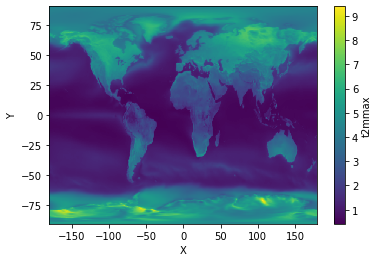

In [15]:
t2mmax_std.plot()

## Compute the climatology and anomalies as 2D maps

The advantage of the `map_blocks` approach is that it doesn't create too many chuncks. That way we can lazily build more operations on top of the anomaly dataset.

Below we count the number of "hot events" (anomaly > 1 degree for two consecutive days) per year.

In [12]:
rolling = t2mmax_anom.rolling(T = 2, center = True)
rolling_hot = rolling.max()
rolling_hot

<xarray.DataArray (T: 14549, Y: 361, X: 576)>
dask.array<where, shape=(14549, 361, 576), dtype=float32, chunksize=(14548, 3, 576), chunktype=numpy.ndarray>
Coordinates:
  * X        (X) float64 -180.0 -179.4 -178.8 -178.1 ... 177.5 178.1 178.8 179.4
  * T        (T) datetime64[ns] 1980-01-01T12:00:00 ... 2019-10-31T12:00:00
  * Y        (Y) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0

In [19]:
yearly_events = (rolling_hot > 1).astype('int').resample(T='YS').sum()
yearly_events.data

,Array,Chunk
Bytes,66.54 MB,13.82 kB
Shape,"(40, 361, 576)","(1, 3, 576)"
Count,31642 Tasks,4840 Chunks
Type,int64,numpy.ndarray


In [20]:
yearly_events.load()

<xarray.DataArray (T: 40, Y: 361, X: 576)>
array([[[197, 197, 197, ..., 197, 197, 197],
        [208, 208, 208, ..., 205, 205, 208],
        [208, 208, 208, ..., 205, 205, 208],
        ...,
        [ 99,  99,  99, ...,  98,  99,  99],
        [103, 103, 103, ..., 103, 103, 103],
        [109, 109, 109, ..., 109, 109, 109]],

       [[176, 176, 176, ..., 176, 176, 176],
        [186, 186, 186, ..., 188, 189, 188],
        [203, 203, 203, ..., 203, 203, 203],
        ...,
        [116, 116, 116, ..., 116, 116, 116],
        [112, 113, 113, ..., 110, 110, 110],
        [111, 111, 111, ..., 111, 111, 111]],

       [[152, 152, 152, ..., 152, 152, 152],
        [160, 160, 160, ..., 160, 160, 160],
        [174, 174, 174, ..., 174, 174, 174],
        ...,
        [147, 147, 147, ..., 147, 145, 145],
        [140, 140, 140, ..., 140, 140, 140],
        [141, 141, 141, ..., 141, 141, 141]],

       ...,

       [[191, 191, 191, ..., 191, 191, 191],
        [188, 188, 188, ..., 188, 188, 188],
        [195, 195, 195, ..., 193, 193, 193],
        ...,
        [216, 216, 215, ..., 215, 216, 216],
        [210, 210, 210, ..., 208, 208, 210],
        [212, 212, 212, ..., 212, 212, 212]],

       [[232, 232, 232, ..., 232, 232, 232],
        [237, 237, 237, ..., 236, 236, 237],
        [234, 234, 234, ..., 234, 234, 234],
        ...,
        [214, 215, 215, ..., 214, 214, 214],
        [210, 210, 210, ..., 210, 210, 210],
        [207, 207, 207, ..., 207, 207, 207]],

       [[ 10,  10,  10, ...,  10,  10,  10],
        [ 10,  10,  10, ...,  10,  10,  10],
        [  9,   9,   9, ...,   9,   9,   9],
        ...,
        [ 16,  16,  16, ...,  16,  16,  16],
        [ 17,  17,  17, ...,  16,  16,  16],
        [ 17,  17,  17, ...,  17,  17,  17]]])
Coordinates:
  * T        (T) datetime64[ns] 1980-01-01 1981-01-01 ... 2018-01-01 2019-01-01
  * X        (X) float64 -180.0 -179.4 -178.8 -178.1 ... 177.5 178.1 178.8 179.4
  * Y        (Y) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0

In [26]:
# skip 2019
yearly_events_mean = yearly_events[:-1].mean(dim='T')
yearly_events_anom = yearly_events[:-1] - yearly_events_mean

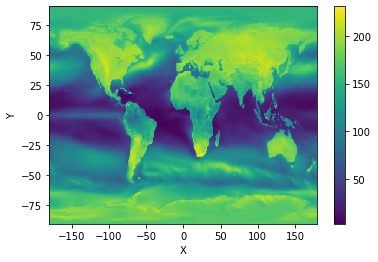

In [27]:
yearly_events_mean.plot()

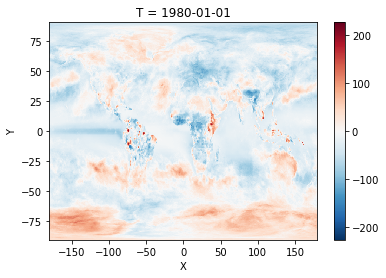

In [30]:
yearly_events_anom[0].plot()

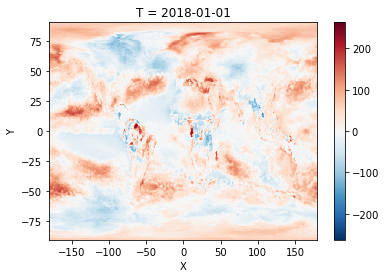

In [31]:
yearly_events_anom[-1].plot()